*Note: You are currently reading this using Google Colaboratory which is a cloud-hosted version of Jupyter Notebook. This is a document containing both text cells for documentation and runnable code cells. If you are unfamiliar with Jupyter Notebook, watch this 3-minute introduction before starting this challenge: https://www.youtube.com/watch?v=inN8seMm7UI*

---

In this challenge, you will predict healthcare costs using a regression algorithm.

You are given a dataset that contains information about different people including their healthcare costs. Use the data to predict healthcare costs based on new data.

The first two cells of this notebook import libraries and the data.

Make sure to convert categorical data to numbers. Use 80% of the data as the `train_dataset` and 20% of the data as the `test_dataset`.

`pop` off the "expenses" column from these datasets to create new datasets called `train_labels` and `test_labels`. Use these labels when training your model.

Create a model and train it with the `train_dataset`. Run the final cell in this notebook to check your model. The final cell will use the unseen `test_dataset` to check how well the model generalizes.

To pass the challenge, `model.evaluate` must return a Mean Absolute Error of under 3500. This means it predicts health care costs correctly within $3500.

The final cell will also predict expenses using the `test_dataset` and graph the results.

In [18]:
# Import libraries. You may or may not use all of these.
#!pip install -q git+https://github.com/tensorflow/docs
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

#try:
  # %tensorflow_version only exists in Colab.
  #%tensorflow_version 2.x
#except Exception:
  #pass
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers

import tensorflow_docs as tfdocs
import tensorflow_docs.plots
import tensorflow_docs.modeling

ModuleNotFoundError: No module named 'tensorflow_docs'

In [ ]:
from sklearn.model_selection import train_test_split

In [19]:
# Import data
#!wget https://cdn.freecodecamp.org/project-data/health-costs/insurance.csv
dataset = pd.read_csv('insurance.csv')
dataset.tail()

,age,sex,bmi,children,smoker,region,expenses
1333,50,male,31.0,3,no,northwest,10600.55
1334,18,female,31.9,0,no,northeast,2205.98
1335,18,female,36.9,0,no,southeast,1629.83
1336,21,female,25.8,0,no,southwest,2007.95
1337,61,female,29.1,0,yes,northwest,29141.36


In [20]:
X = dataset.drop(['expenses'], axis = 1)
y = dataset['expenses']
train_dataset, test_dataset,train_labels, test_labels = train_test_split(X,y)

In [21]:
cat_cols = list(dataset.select_dtypes(include = 'object').columns)
num_cols = list(dataset.select_dtypes(exclude = 'object').columns)
num_cols.remove('expenses')

In [91]:
def make_ds(data, y, batch_size = 5, shuffle = True):
    df = {key : val[:, tf.newaxis] for key,val in data.items()}
    ds = tf.data.Dataset.from_tensor_slices((dict(df), y))
    if shuffle:
        ds = ds.shuffle(buffer_size = len(data))
    ds = ds.batch(batch_size)
    ds = ds.prefetch(batch_size)
    return ds
train_ds = make_ds(train_dataset, train_labels)
test_ds = make_ds(test_dataset, test_labels)

In [83]:
[(train_f, l_b)] = ds.take(1)
print(l_b)

tf.Tensor([15230.32  6079.67 11674.13  2689.5  13725.47], shape=(5,), dtype=float64)


In [45]:
def normalization_layer(name, ds):
    normalizer = layers.Normalization(axis = None)
    feature_ds = ds.map(lambda x,y : x[name])
    normalizer.adapt(feature_ds)
    return normalizer

In [84]:
train_encoded_in = []
all_in = []
for col in num_cols:
    num_col = tf.keras.Input(shape = (1,), name = col, dtype = 'int64')
    encoded = normalization_layer(col, train_ds)
    encoded_num_col = encoded(num_col)
    all_in.append(num_col)
    encoded_in.append(encoded_num_col)
encoded_in

[<KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'normalization_35')>,
 <KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'normalization_36')>,
 <KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'normalization_37')>]

In [49]:
def cat_encoding_layer(name, dataset, dtype, max_token = None):
    ind = layers.StringLookup(max_tokens = max_token)
    feature_ds = ds.map(lambda x,y : x[name])
    ind.adapt(feature_ds)
    encoder = layers.CategoryEncoding(num_tokens = ind.vocabulary_size())
    return lambda feature: encoder(ind(feature))

In [85]:
for col in cat_cols:
    cat_col = tf.keras.Input(shape = (1,), name = col, dtype = 'string')
    encode_layer = cat_encoding_layer(col,ds,'string')
    encoded = encode_layer(cat_col)
    all_in.append(cat_col)
    encoded_in.append(encoded)
encoded_in

[<KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'normalization_35')>,
 <KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'normalization_36')>,
 <KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'normalization_37')>,
 <KerasTensor: shape=(None, 3) dtype=float32 (created by layer 'category_encoding_19')>,
 <KerasTensor: shape=(None, 3) dtype=float32 (created by layer 'category_encoding_20')>,
 <KerasTensor: shape=(None, 5) dtype=float32 (created by layer 'category_encoding_21')>]

In [86]:
all_f = layers.concatenate(encoded_in)
x =  tf.keras.layers.Dense(64,activation = 'relu')(all_f)
x = tf.keras.layers.Dense(64,activation = 'relu')(x)
output = tf.keras.layers.Dense(1)(x)
model = keras.Model(all_in, output)
model.compile(optimizer ='rmsprop', loss = 'mse', metrics = ['mae','mse'])

In [88]:
model.fit(ds, epochs = 50)

Epoch 1/50
201/201 [==============================] - 3s 16ms/step - loss: 93169960.0000 - mae: 7452.5156 - mse: 93169960.0000 0s - loss: 94582816.0000 - mae: 74
Epoch 2/50
201/201 [==============================] - 3s 16ms/step - loss: 83756176.0000 - mae: 6990.7734 - mse: 83756176.0000 1s - loss: 81708360.0000 - mae: 6906.0557 - ms - ETA: 1s - loss: 81119200.0000 - mae: 6888.5688 - mse: - ETA: 0s - loss: 81347544.00
Epoch 3/50
201/201 [==============================] - 4s 18ms/step - loss: 74684264.0000 - mae: 6595.2876 - mse: 74684264.0000 0s - loss: 74062
Epoch 4/50
201/201 [==============================] - 3s 16ms/step - loss: 66110116.0000 - mae: 6050.0391 - mse: 66110116.0000 1s - loss: 59554784.0000 - mae: 5825.910 - ETA: 0s - loss: 64097724.0000 - mae: 5926.6
Epoch 5/50
201/201 [==============================] - 3s 17ms/step - loss: 58465908.0000 - mae: 5629.1777 - mse: 58465908.0000 3s - loss: 63290920.0000 - mae: 5909.4673 - mse: 63290920.00 - ETA: 3s - loss: 57823484.0000 

201/201 [==============================] - 3s 16ms/step - loss: 27417138.0000 - mae: 3192.9534 - mse: 27417138.0000 1s - loss: 26621754.00
Epoch 47/50
201/201 [==============================] - 3s 15ms/step - loss: 27153880.0000 - mae: 3219.3289 - mse: 27153880.0000
Epoch 48/50
201/201 [==============================] - 3s 14ms/step - loss: 26894146.0000 - mae: 3183.9006 - mse: 26894146.0000
Epoch 49/50
201/201 [==============================] - 2s 12ms/step - loss: 26711022.0000 - mae: 3172.3564 - mse: 26711022.0000
Epoch 50/50
201/201 [==============================] - 3s 13ms/step - loss: 26484844.0000 - mae: 3144.7061 - mse: 26484844.0000


67/67 - 1s - loss: 27525548.0000 - mae: 3285.9575 - mse: 27525548.0000 - 548ms/epoch - 8ms/step
Testing set Mean Abs Error: 3285.96 expenses
You passed the challenge. Great job!


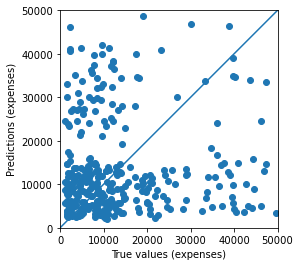

In [96]:
# RUN THIS CELL TO TEST YOUR MODEL. DO NOT MODIFY CONTENTS.
# Test model by checking how well the model generalizes using the test set.
loss, mae, mse = model.evaluate(test_ds ,verbose=2)

print("Testing set Mean Abs Error: {:5.2f} expenses".format(mae))

if mae < 3500:
  print("You passed the challenge. Great job!")
else:
  print("The Mean Abs Error must be less than 3500. Keep trying.")

# Plot predictions.
test_predictions = model.predict(test_ds).flatten()

a = plt.axes(aspect='equal')
plt.scatter(test_labels, test_predictions)
plt.xlabel('True values (expenses)')
plt.ylabel('Predictions (expenses)')
lims = [0, 50000]
plt.xlim(lims)
plt.ylim(lims)
_ = plt.plot(lims,lims)

In [7]:
X =pd.get_dummies(X)
mean = X.mean()
X -= mean
std = X.std()
X /= std
X

,age,bmi,children,sex_female,sex_male,smoker_no,smoker_yes,region_northeast,region_northwest,region_southeast,region_southwest
0,-1.438227,-0.453476,-0.908274,1.010141,-1.010141,-1.969850,1.969850,-0.565056,-0.566206,-0.611095,1.764821
1,-1.509401,0.513994,-0.078738,-0.989221,0.989221,0.507273,-0.507273,-0.565056,-0.566206,1.635183,-0.566206
2,-0.797655,0.382811,1.580335,-0.989221,0.989221,0.507273,-0.507273,-0.565056,-0.566206,1.635183,-0.566206
3,-0.441782,-1.306161,-0.908274,-0.989221,0.989221,0.507273,-0.507273,-0.565056,1.764821,-0.611095,-0.566206
4,-0.512957,-0.289498,-0.908274,-0.989221,0.989221,0.507273,-0.507273,-0.565056,1.764821,-0.611095,-0.566206
...,...,...,...,...,...,...,...,...,...,...,...
1333,0.768185,0.054855,1.580335,-0.989221,0.989221,0.507273,-0.507273,-0.565056,1.764821,-0.611095,-0.566206
1334,-1.509401,0.202436,-0.908274,1.010141,-1.010141,0.507273,-0.507273,1.768415,-0.566206,-0.611095,-0.566206
1335,-1.509401,1.022325,-0.908274,1.010141,-1.010141,0.507273,-0.507273,-0.565056,-0.566206,1.635183,-0.566206
1336,-1.295877,-0.797830,-0.908274,1.010141,-1.010141,0.507273,-0.507273,-0.565056,-0.566206,-0.611095,1.764821


In [24]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(64,activation = 'relu',input_shape = (X.shape[1],)),
    tf.keras.layers.Dense(64, activation = 'relu'),
    tf.keras.layers.Dense(32, activation = 'relu'),
    tf.keras.layers.Dense(1),
])
model.compile(optimizer ='rmsprop', loss = 'mse', metrics = ['mae','mse'])

In [25]:
train_dataset, test_dataset,train_labels, test_labels = train_test_split(X,y)
model.fit(train_dataset, train_labels, epochs = 45)

Epoch 1/45
32/32 [==============================] - 5s 10ms/step - loss: 333444448.0000 - mae: 13532.7773 - mse: 333444448.0000
Epoch 2/45
32/32 [==============================] - 0s 10ms/step - loss: 332764096.0000 - mae: 13510.4775 - mse: 332764096.0000
Epoch 3/45
32/32 [==============================] - 0s 12ms/step - loss: 331039264.0000 - mae: 13457.0801 - mse: 331039264.0000
Epoch 4/45
32/32 [==============================] - 0s 14ms/step - loss: 327575040.0000 - mae: 13357.9561 - mse: 327575040.0000: 0s - loss: 267917136.0000 - mae: 12440.2031 - mse: 2679171
Epoch 5/45
32/32 [==============================] - 1s 15ms/step - loss: 322086176.0000 - mae: 13198.7344 - mse: 322086176.0000: 0s - loss: 323568416.0000 - mae: 13063.5332 - mse: 323568416
Epoch 6/45
32/32 [==============================] - 0s 13ms/step - loss: 313573536.0000 - mae: 12959.2500 - mse: 313573536.0000
Epoch 7/45
32/32 [==============================] - 0s 14ms/step - loss: 301253952.0000 - mae: 12621.9834 - ms

11/11 - 0s - loss: 24379714.0000 - mae: 3257.9182 - mse: 24379714.0000
Testing set Mean Abs Error: 3257.92 expenses
You passed the challenge. Great job!


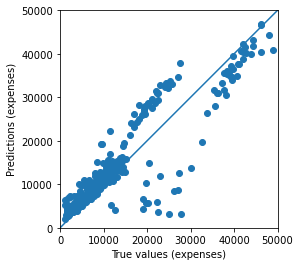

In [27]:
# RUN THIS CELL TO TEST YOUR MODEL. DO NOT MODIFY CONTENTS.
# Test model by checking how well the model generalizes using the test set.
loss, mae, mse = model.evaluate(test_dataset, test_labels, verbose=2)

print("Testing set Mean Abs Error: {:5.2f} expenses".format(mae))

if mae < 3500:
  print("You passed the challenge. Great job!")
else:
  print("The Mean Abs Error must be less than 3500. Keep trying.")

# Plot predictions.
test_predictions = model.predict(test_dataset).flatten()

a = plt.axes(aspect='equal')
plt.scatter(test_labels, test_predictions)
plt.xlabel('True values (expenses)')
plt.ylabel('Predictions (expenses)')
lims = [0, 50000]
plt.xlim(lims)
plt.ylim(lims)
_ = plt.plot(lims,lims)
